In [1]:
import pickle

import pandas as pd
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

# from constants import FINE_TUNED_BERT_MODEL_PATH, TRAIN_DATA_CSV, TEST_DATA_CSV, TARGET_SCALER_PATH, MODELS_PATH

## Load the data and add special tokens

In [2]:
# BATCH_SIZE = 2
BATCH_SIZE = 32
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# SLICE: int | None = 10
SLICE = None

df_train = pd.read_csv("train_data.csv", dtype={"unique_id": str})[:SLICE]
df_test = pd.read_csv("test_data.csv", dtype={"unique_id": str})[:SLICE]

# df_train = pd.read_csv(TRAIN_DATA_CSV, dtype={"unique_id": str})[:SLICE]
# df_test = pd.read_csv(TEST_DATA_CSV, dtype={"unique_id": str})[:SLICE]

DEVICE

device(type='cuda')

In [3]:
with open("target_scaler.pkl", "rb") as f:
    target_scaler = pickle.load(f)

# with open(TARGET_SCALER_PATH, "rb") as f:
#     target_scaler = pickle.load(f)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    "dumitrescustefan/bert-base-romanian-uncased-v1", do_lower_case=True, add_special_tokens=True, max_length=512, padding=True, truncation=True
)
bert_model = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1")
bert_model.to(DEVICE)

torch.cuda.empty_cache()

bert_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/411k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/500M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [5]:
def compute_metrics(predictions, ground_truths):
    mae = mean_absolute_error(ground_truths, predictions)
    mse = mean_squared_error(ground_truths, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(ground_truths, predictions)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


def plot_loss_and_metrics(history, metrics_history, SLICE_START=10):
    plt.plot(history["train_loss"][SLICE_START:], label="train loss")
    plt.plot(history["test_loss"][SLICE_START:], label="test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(metrics_history["train_mae"][SLICE_START:], label="train mae")
    plt.plot(metrics_history["test_mae"][SLICE_START:], label="test mae")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

    plt.plot(metrics_history["train_rmse"][SLICE_START:], label="train rmse")
    plt.plot(metrics_history["test_rmse"][SLICE_START:], label="test rmse")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

    plt.plot(metrics_history["train_r2"][SLICE_START:], label="train r2")
    plt.plot(metrics_history["test_r2"][SLICE_START:], label="test r2")
    plt.xlabel("Epoch")
    plt.ylabel("R2")
    plt.legend()
    plt.show()

    plt.plot(metrics_history["train_mse"][SLICE_START:], label="train mse")
    plt.plot(metrics_history["test_mse"][SLICE_START:], label="test mse")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()


def print_metrics_table(metrics_history):
    headers = ["Epoch", "MAE", "RMSE", "R2", "MSE"]

    # Prepare train data
    train_data = [
        [
            len(metrics_history["train_mae"]) - 1,
            f"{metrics_history['train_mae'][-1]:.5f}",
            f"{metrics_history['train_rmse'][-1]:.5f}",
            f"{metrics_history['train_r2'][-1]:.5f}",
            f"{metrics_history['train_mse'][-1]:.5f}",
        ]
    ]

    # Prepare test data
    test_data = [
        [
            len(metrics_history["test_mae"]) - 1,
            f"{metrics_history['test_mae'][-1]:.5f}",
            f"{metrics_history['test_rmse'][-1]:.5f}",
            f"{metrics_history['test_r2'][-1]:.5f}",
            f"{metrics_history['test_mse'][-1]:.5f}",
        ]
    ]

    # Print train metrics table
    print("Train Metrics")
    print(tabulate(train_data, headers=headers, tablefmt="grid"))

    # Print test metrics table
    print("\nTest Metrics")
    print(tabulate(test_data, headers=headers, tablefmt="grid"))

## Tokenize inputs and create datasets

In [6]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        price = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item, price

    def __len__(self):
        return len(self.encodings["input_ids"])


train_texts = list(df_train["input"])
train_prices = list(df_train["price_std"])
eval_texts = list(df_test["input"])
eval_prices = list(df_test["price_std"])

# Tokenizing texts
train_encodings = tokenizer(train_texts, max_length=512, truncation=True, padding=True)
eval_encodings = tokenizer(eval_texts, max_length=512, truncation=True, padding=True)

train_dataset = CustomDataset(train_encodings, train_prices)
eval_dataset = CustomDataset(eval_encodings, eval_prices)

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class BERTRegressor(nn.Module):
    def __init__(self):
        super(BERTRegressor, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        outputs = outputs[1]  # Use the output of the [CLS] token
        out = self.fc(outputs)
        return out

In [9]:
model = BERTRegressor().to(DEVICE)
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=0.00001)

history = {"train_loss": [], "test_loss": []}
metrics_history = {"train_mae": [], "test_mae": [], "train_rmse": [], "test_rmse": [], "train_r2": [], "test_r2": [], "train_mse": [], "test_mse": []}

In [10]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    all_train_predictions = []
    all_train_ground_truths = []
    for texts, prices in tqdm(train_loader):
        input_ids = texts["input_ids"].to(DEVICE)
        attention_mask = texts["attention_mask"].to(DEVICE)
        prices = prices.to(DEVICE)
        prices = prices.view(-1, 1)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, prices.float())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy())
        unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy())

        all_train_predictions.extend(unnorm_outputs)
        all_train_ground_truths.extend(unnorm_prices)

    train_metrics = compute_metrics(all_train_predictions, all_train_ground_truths)
    metrics_history["train_mae"].append(train_metrics["MAE"])
    metrics_history["train_mse"].append(train_metrics["MSE"])
    metrics_history["train_rmse"].append(train_metrics["RMSE"])
    metrics_history["train_r2"].append(train_metrics["R2"])

    avg_train_loss = np.sum(train_losses) / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")
    print(f"Epoch {epoch + 1}, Train Metrics: {train_metrics}")

    model.eval()
    with torch.no_grad():
        validation_losses = []
        all_test_predictions = []
        all_test_ground_truths = []
        for texts, prices in eval_loader:
            input_ids = texts["input_ids"].to(DEVICE)
            attention_mask = texts["attention_mask"].to(DEVICE)
            prices = prices.to(DEVICE)
            prices = prices.view(-1, 1)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            val_loss = criterion(outputs, prices.float())

            validation_losses.append(val_loss.item())

            unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy())
            unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy())

            all_test_predictions.extend(unnorm_outputs)
            all_test_ground_truths.extend(unnorm_prices)

        avg_val_loss = np.sum(validation_losses) / len(eval_loader)
        history["test_loss"].append(avg_val_loss)

        test_metrics = compute_metrics(all_test_predictions, all_test_ground_truths)
        metrics_history["test_mae"].append(test_metrics["MAE"])
        metrics_history["test_mse"].append(test_metrics["MSE"])
        metrics_history["test_rmse"].append(test_metrics["RMSE"])
        metrics_history["test_r2"].append(test_metrics["R2"])

        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")
        print(f"Epoch {epoch + 1}, Test Metrics: {test_metrics}")

    # torch.save(model.state_dict(), MODELS_PATH / f"fine_tuned_bert_model_{epoch+1}.pth")
    torch.save(model.state_dict(), f=f"fine_tuned_bert_model_{epoch+1}.pth")

100%|██████████| 795/795 [05:01<00:00,  2.63it/s]


Epoch 1, Train Loss: 0.40011195279892137
Epoch 1, Train Metrics: {'MAE': 4159.3804, 'MSE': 31786712.0, 'RMSE': 5637.9707, 'R2': 0.5979961327153009}
Epoch 1, Validation Loss: 0.2654957842437466
Epoch 1, Test Metrics: {'MAE': 3270.6475, 'MSE': 21085558.0, 'RMSE': 4591.9014, 'R2': 0.7336516719698314}


100%|██████████| 795/795 [05:01<00:00,  2.64it/s]


Epoch 2, Train Loss: 0.23943711615770868
Epoch 2, Train Metrics: {'MAE': 3155.3833, 'MSE': 19021186.0, 'RMSE': 4361.3286, 'R2': 0.7594406821154978}
Epoch 2, Validation Loss: 0.22689627227022421
Epoch 2, Test Metrics: {'MAE': 3009.9402, 'MSE': 18025082.0, 'RMSE': 4245.5957, 'R2': 0.772310970048924}


100%|██████████| 795/795 [05:01<00:00,  2.64it/s]


Epoch 3, Train Loss: 0.1949259210869951
Epoch 3, Train Metrics: {'MAE': 2840.5923, 'MSE': 15469815.0, 'RMSE': 3933.1685, 'R2': 0.8043545510239073}
Epoch 3, Validation Loss: 0.2157517649121021
Epoch 3, Test Metrics: {'MAE': 2911.0142, 'MSE': 17135100.0, 'RMSE': 4139.4565, 'R2': 0.7835530396279882}


100%|██████████| 795/795 [05:01<00:00,  2.64it/s]


Epoch 4, Train Loss: 0.16650675541762286
Epoch 4, Train Metrics: {'MAE': 2607.9856, 'MSE': 13227684.0, 'RMSE': 3636.9883, 'R2': 0.8327105952044719}
Epoch 4, Validation Loss: 0.20367787093223638
Epoch 4, Test Metrics: {'MAE': 2795.3618, 'MSE': 16173894.0, 'RMSE': 4021.678, 'R2': 0.7956947880333324}


100%|██████████| 795/795 [05:01<00:00,  2.64it/s]


Epoch 5, Train Loss: 0.14291454930350467
Epoch 5, Train Metrics: {'MAE': 2427.154, 'MSE': 11349614.0, 'RMSE': 3368.9187, 'R2': 0.8564624026747559}
Epoch 5, Validation Loss: 0.19035080786625944
Epoch 5, Test Metrics: {'MAE': 2655.99, 'MSE': 15123841.0, 'RMSE': 3888.9382, 'R2': 0.8089588457091847}


100%|██████████| 795/795 [05:01<00:00,  2.63it/s]


Epoch 6, Train Loss: 0.12354027958785962
Epoch 6, Train Metrics: {'MAE': 2262.0706, 'MSE': 9815063.0, 'RMSE': 3132.9001, 'R2': 0.8758697276265421}
Epoch 6, Validation Loss: 0.20086652821107726
Epoch 6, Test Metrics: {'MAE': 2725.0176, 'MSE': 15952121.0, 'RMSE': 3994.0107, 'R2': 0.7984961706464002}


100%|██████████| 795/795 [05:01<00:00,  2.64it/s]


Epoch 7, Train Loss: 0.10711003814900072
Epoch 7, Train Metrics: {'MAE': 2124.2717, 'MSE': 8506428.0, 'RMSE': 2916.5781, 'R2': 0.8924199245837188}
Epoch 7, Validation Loss: 0.21039132635347807
Epoch 7, Test Metrics: {'MAE': 2861.5771, 'MSE': 16708814.0, 'RMSE': 4087.6416, 'R2': 0.7889377967341836}


100%|██████████| 795/795 [05:01<00:00,  2.64it/s]


Epoch 8, Train Loss: 0.09393758161825204
Epoch 8, Train Metrics: {'MAE': 1981.5851, 'MSE': 7458449.0, 'RMSE': 2731.016, 'R2': 0.9056736285846981}
Epoch 8, Validation Loss: 0.19361762721185108
Epoch 8, Test Metrics: {'MAE': 2676.421, 'MSE': 15378508.0, 'RMSE': 3921.5442, 'R2': 0.805741925723059}


100%|██████████| 795/795 [05:01<00:00,  2.64it/s]


Epoch 9, Train Loss: 0.08123544546652516
Epoch 9, Train Metrics: {'MAE': 1860.2706, 'MSE': 6451566.5, 'RMSE': 2539.9934, 'R2': 0.9184075819782406}
Epoch 9, Validation Loss: 0.2592902353136384
Epoch 9, Test Metrics: {'MAE': 3045.968, 'MSE': 20592464.0, 'RMSE': 4537.892, 'R2': 0.7398803557469849}


100%|██████████| 795/795 [05:01<00:00,  2.63it/s]


Epoch 10, Train Loss: 0.07252592208250513
Epoch 10, Train Metrics: {'MAE': 1761.7288, 'MSE': 5761578.0, 'RMSE': 2400.3286, 'R2': 0.9271338108770008}
Epoch 10, Validation Loss: 0.2125569274602224
Epoch 10, Test Metrics: {'MAE': 2754.6147, 'MSE': 16880870.0, 'RMSE': 4108.634, 'R2': 0.7867644191765868}


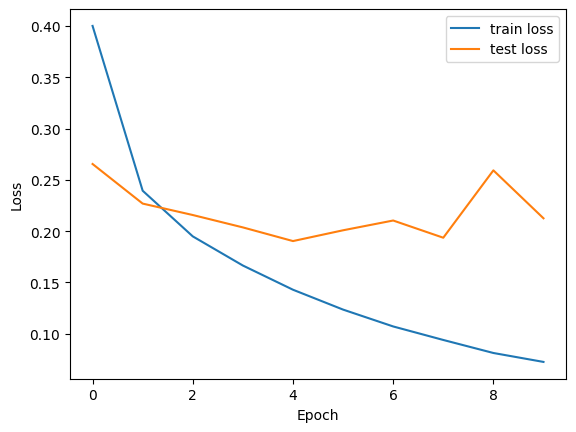

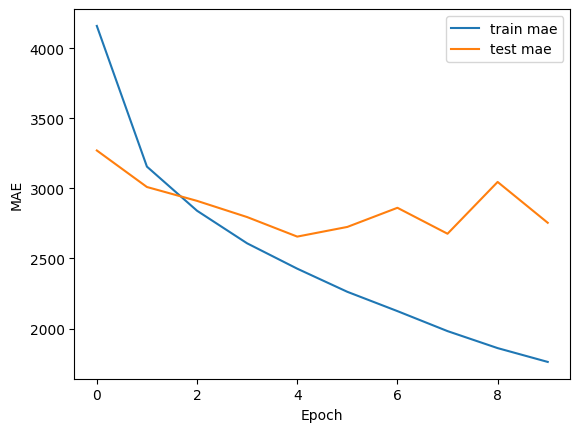

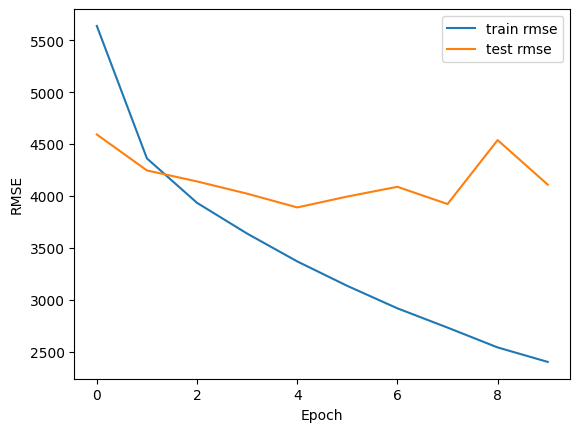

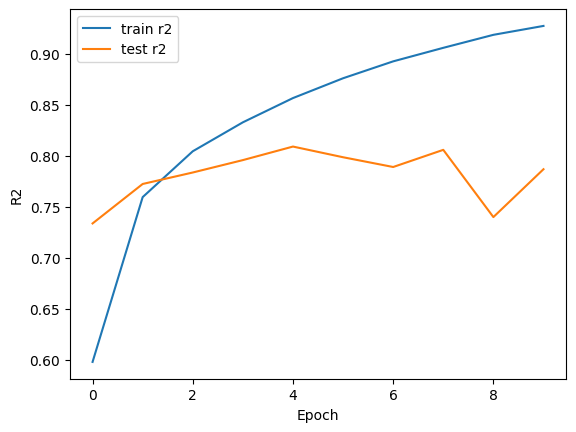

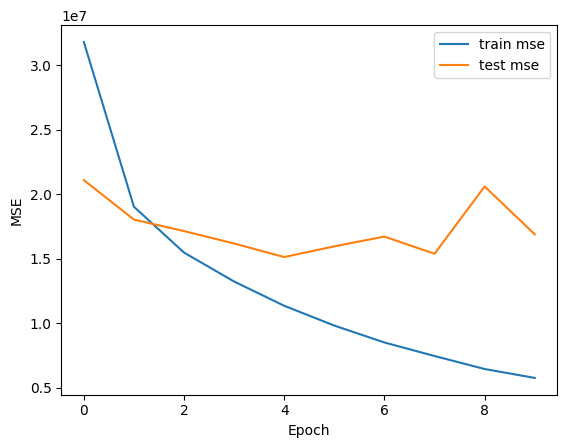

Train Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|       9 | 1761.73 | 2400.33 | 0.92713 | 5.76158e+06 |
+---------+---------+---------+---------+-------------+

Test Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|       9 | 2754.61 | 4108.63 | 0.78676 | 1.68809e+07 |
+---------+---------+---------+---------+-------------+


In [11]:
plot_loss_and_metrics(history, metrics_history, SLICE_START=0)
print_metrics_table(metrics_history)

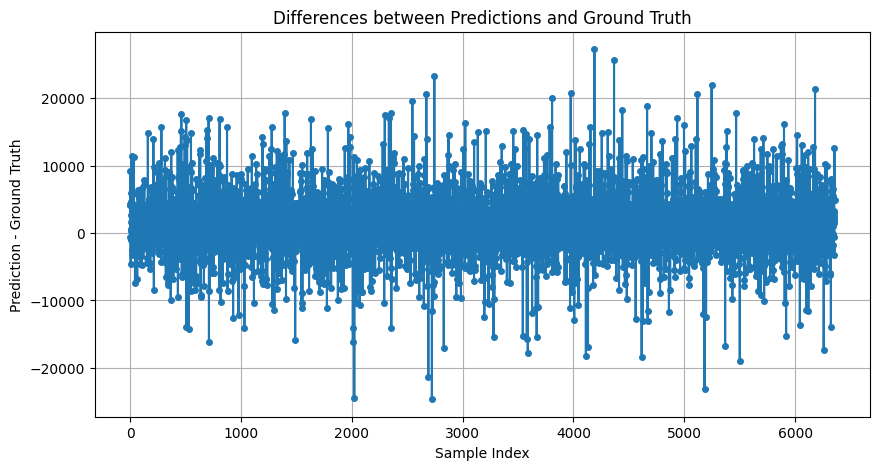

TypeError: unsupported format string passed to numpy.ndarray.__format__

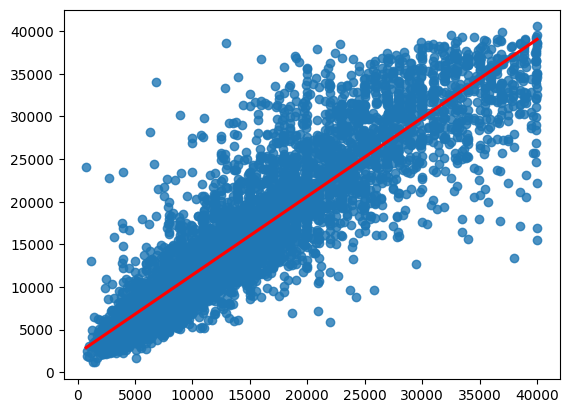

In [12]:
differences = []
abs_differences = []
gt = []
pred = []

model.eval()
with torch.no_grad():
    for texts, prices in eval_loader:
        input_ids = texts["input_ids"].to(DEVICE)
        attention_mask = texts["attention_mask"].to(DEVICE)
        prices = prices.to(DEVICE)
        prices = prices.view(-1, 1)

        outputs = model(input_ids, attention_mask)

        unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy())
        unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy())

        for output, target in zip(unnorm_outputs, unnorm_prices):
            diff = output - target
            abs_diff = abs(diff)
            differences.append(diff)
            abs_differences.append(abs_diff)
            gt.append(target)
            pred.append(output)

# Plotting the differences
plt.figure(figsize=(10, 5))
plt.plot(differences, marker="o", linestyle="-", markersize=4)
plt.title("Differences between Predictions and Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("Prediction - Ground Truth")
plt.grid(True)
plt.show()

sns.regplot(x=gt, y=pred, ci=None, scatter=True, line_kws={"color": "red"})

# calculate the average difference
average_abs_diff = sum(abs_differences) / len(abs_differences)
print(f"Average absolute difference: {average_abs_diff:.2f}")

In [ ]:
# torch.save(model.state_dict(), f=FINE_TUNED_BERT_MODEL_PATH)
torch.save(model.state_dict(), f="fine_tuned_bert_model.pth")

# Inference example

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1", do_lower_case=True,
#                                           add_special_tokens=True, max_length=512, padding=True, truncation=True)
# bert_model = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1")
# bert_model.to(DEVICE)
#
#
# class BERTRegressor(nn.Module):
#     def __init__(self):
#         super(BERTRegressor, self).__init__()
#         self.bert = bert_model
#         self.fc = nn.Linear(768, 1)
#
#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids, attention_mask)
#         outputs = outputs[1]  # Use the output of the [CLS] token
#         return outputs
#
#
# model = BERTRegressor().to(DEVICE)
#
# model.load_state_dict(torch.load(FINE_TUNED_BERT_MODEL_PATH))
# model.to(DEVICE)
# model.eval()
#
# with torch.no_grad():
#     for texts, prices in eval_loader:
#         input_ids = texts["input_ids"].to(DEVICE)
#         attention_mask = texts["attention_mask"].to(DEVICE)
#         prices = prices.to(DEVICE)
#
#         outputs = model(input_ids, attention_mask)
#
#         embeddings = outputs.cpu().detach().numpy()
#         print(embeddings.shape)